# About VinBigData Chest X-ray Abnormalities

DICOM은 의료 영상의 국제 표준이고,
PACS는 '의학영상정보시스템'의 약자로 의료영상을 관리하는 프로그램입니다.  

여러 회사에서 다양한 방식으로 PACS를 구현하고 있고, 병원에서는 자기 분야에 맞는 PACS를 가져다 씁니다.

쉽게말해 DICOM은 파일 형식이고, PACS는 DICOM 파일을 보는 소프트웨어입니다. 
일반인도 DICOM 뷰어를 다운로드받아 DICOM 형식의 파일을 읽어볼 수 있습니다.


> 이 대회에서는 흉부 방사선 촬영에서 14가지 유형의 흉부 이상을 자동으로 현지화하고 분류합니다.

> 숙련된 방사선사가 주석을 단 18,000개의 스캔으로 구성된 데이터 세트를 사용할 수 있습니다. 

> 15,000개의 독립 레이블 이미지를 사용하여 모델을 교육할 수 있으며 3,000개의 이미지 테스트 세트에서 평가됩니다. 

> 이러한 주석들은 VinBigData의 웹 기반 플랫폼인 VinLab을 통해 수집되었습니다. 데이터 세트 구축에 대한 자세한 내용은 최근 논문 "VinDr-CXR: 방사선 전문의 주석이 포함된 흉부 X선의 열린 데이터 세트"에서 확인할 수 있습니다. https://arxiv.org/pdf/2012.15029.pdf

논문내의 모든 특징을 사용하지 않았다.

- 0 - Aortic enlargement / 2348
- 1 - Atelectasis / 62
- 2 - Calcification / 177
- 3 - Cardiomegaly / 1817
- 4 - Consolidation / 121
- 5 - ILD / 152
- 6 - Infiltration / 245
- 7 - Lung Opacity / 547
- 8 - Nodule/Mass / 410
- 9 - Other lesion / 363
- 10 - Pleural effusion / 634
- 11 - Pleural thickening / 882
- 12 - Pneumothorax / 58
- 13 - Pulmonary fibrosis / 1017

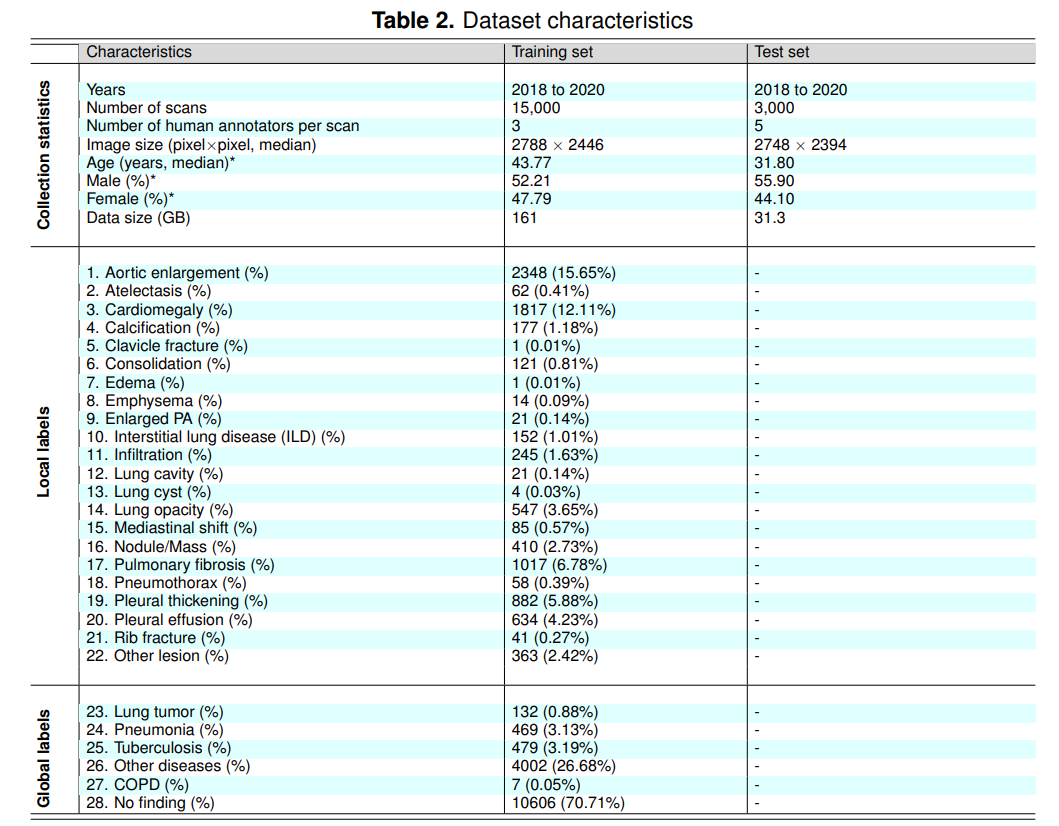

![](https://i.imgur.com/QWmbhXx.png)

# 1. Dicom to Numpy array

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pydicom
from glob import glob
from tqdm.notebook import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import warnings
warnings.filterwarnings('ignore')

> All images in dataset are DICOM format. So we need to convert data from DICOM to numpy array. Original dicom2array function in [raddar's notebook](https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way)

In [ ]:
dataset_dir = '../input/vinbigdata-chest-xray-abnormalities-detection'

In [ ]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data
        
    
def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()


def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()
    
# def draw_bboxes(img, boxes, thickness=10, color=(255, 0, 0), img_size=(500,500)):
#     img_copy = img.copy()
#     if len(img_copy.shape) == 2:
#         img_copy = np.stack([img_copy, img_copy, img_copy], axis=-1)
#     for box in boxes:
#         img_copy = cv2.rectangle(
#             img_copy,
#             (int(box[0]), int(box[1])),
#             (int(box[2]), int(box[3])),
#             color, thickness)
#     if img_size is not None:
#         img_copy = cv2.resize(img_copy, img_size)
#     return img_copy

In [ ]:
dicom_paths = glob(f'{dataset_dir}/train/*.dicom')
imgs = [dicom2array(path) for path in dicom_paths[:4]]
plot_imgs(imgs)

Maybe, you can try some preprocess like equalize histogram. You can see the difference between before and after

In [ ]:
imgs = [exposure.equalize_hist(img) for img in imgs]
plot_imgs(imgs)

# 2. EDA csv

### Now, we will try some EDA steps to find out important features in this data set

In [ ]:
from bokeh.plotting import figure as bokeh_figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs
import pandas as pd
from PIL import Image
from sklearn import preprocessing
import random
from random import randint

- image_id -고유 한 이미지 식별자
- class_name -감지 된 개체의 클래스 이름 (또는 "찾을 수 없음")
- class_id -감지 된 개체의 클래스 ID
- rad_id -관찰 한 방사선과 의사의 ID
- x_min -개체 경계 상자의 최소 X 좌표
- y_min -개체 경계 상자의 최소 Y 좌표
- x_max -개체 경계 상자의 최대 X 좌표
- y_max -개체 경계 상자의 최대 Y 좌표

In [ ]:
def get_bbox_area(row):
    return (row['x_max']-row['x_min'])*(row['y_max']-row['y_min'])

train_df = pd.read_csv(f'{dataset_dir}/train.csv')
le = preprocessing.LabelEncoder()  # encode rad_id
train_df['rad_label'] = le.fit_transform(train_df['rad_id'])

finding_df = train_df[train_df['class_name'] != 'No finding']
finding_df['bbox_area'] = finding_df.apply(get_bbox_area, axis=1)
finding_df.head()

## 2.1 Plot bounding box

In [ ]:
imgs = []
img_ids = finding_df['image_id'].values
class_ids = finding_df['class_id'].unique()

# map label_id to specify color
label2color = {class_id:[randint(0,255) for i in range(3)] for class_id in class_ids}
thickness = 3
scale = 5


for i in range(8):
    img_id = random.choice(img_ids)
    img_path = f'{dataset_dir}/train/{img_id}.dicom'
    img = dicom2array(path=img_path)
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
    img = np.stack([img, img, img], axis=-1)
    
    boxes = finding_df.loc[finding_df['image_id'] == img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values/scale
    labels = finding_df.loc[finding_df['image_id'] == img_id, ['class_id']].values.squeeze()
    
    for label_id, box in zip(labels, boxes):
        color = label2color[label_id]
        img = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, thickness
    )
    img = cv2.resize(img, (500,500))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)

You can see that: in each image, there are many overlapping boxes. Note that a key part of this competition is working with ground truth from multiple radiologists. I guess it is a key to get best rank in this competition if you handle it skillfully.

## 2.2 Plot histogram

We will try to plot some histograms.  The hist_hover function allows you to interact very well with chart

In [ ]:
def hist_hover(dataframe, column, color=["#94c8d8", "#ea5e51"], bins=30, title="", value_range=None):
    """
    Plot histogram
    """
    hist, edges = np.histogram(dataframe[column], bins=bins, range=value_range)
    hist_frame = pd.DataFrame({
        column: hist,
        "left": edges[:-1],
        "right": edges[1:]
    })
    hist_frame["interval"] = ["%d to %d" %
                              (left, right) for left, right in zip(edges[:-1], edges[1:])]
    src = ColumnDataSource(hist_frame)
    plot = bokeh_figure(
        plot_height=400, plot_width=600,
        title=title, x_axis_label=column,
        y_axis_label="Count"
    )
    plot.quad(
        bottom=0, top=column, left="left", right="right",
        source=src, fill_color=color[0], line_color="#35838d",
        fill_alpha=0.7, hover_fill_alpha=0.7,
        hover_fill_color=color[1]
    )
    hover = HoverTool(
        tooltips=[("Interval", "@interval"), ("Count", str(f"@{column}"))]
    )
    plot.add_tools(hover)
    output_notebook()
    show(plot)
    
    
hist_hover(train_df, column='class_id')

you can see the imbalance between image qualtity of each class

In [ ]:
#Note that a key part of this competition is working with ground truth from multiple radiologists.
hist_hover(train_df, column='rad_label')

The imbalance between image qualtity of each radiologist

In [ ]:
## histogram of bbox area
hist_hover(finding_df, column='bbox_area')

After some EDA steps, we recognize that the dataset fairly imbalance in many aspects. Maybe, we need to use some augmentation method to resolve the problem.


# 3. Don't forget to upvote :D